# <font color="#1d479b">Contexte</font>

Pour atteindre l'objectif de **ville neutre en émissions de carbone en 2050**, la ville de **Seattle** s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.



## 1. **Importer les bibliothèques :**

In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from category_encoders import TargetEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
# Ignorer les avertissements spécifiques de mauvaise condition de matrice
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Importation des nouveaux modèles
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pickle
import shap

C:\Users\bille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. **Charger le jeu de donnée:**

In [2]:
# Charger les dtypes depuis le fichier JSON
with open("Data/dtypes-GHGEmissions.json", "r") as f:
    dtypes_dict_GHGEmissions = json.load(f)

data = pd.read_csv("Data/building-GHGEmissions-cleaned.csv", dtype=dtypes_dict_GHGEmissions)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,...,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup,DistanceToCenter,TotalGHGEmissions_log
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,60.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.800050,5.525373
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,61.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas,0.787077,5.693261
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,43.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas,0.970109,7.645053
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,56.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.944139,5.660979
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,75.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas,1.048092,6.226556


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   OSEBuildingID                               1387 non-null   object 
 1   BuildingType                                1387 non-null   object 
 2   PrimaryPropertyType                         1387 non-null   object 
 3   ZipCode                                     1387 non-null   object 
 4   CouncilDistrictCode                         1387 non-null   object 
 5   Neighborhood                                1387 non-null   object 
 6   LargestPropertyUseType                      1387 non-null   object 
 7   SecondLargestPropertyUseType                1387 non-null   object 
 8   ThirdLargestPropertyUseType                 1387 non-null   object 
 9   ENERGYSTARScore                             930 non-null    float64
 10  TotalUseType

In [4]:
data.describe()

,ENERGYSTARScore,TotalUseTypeNumber,BuildingAge,LargestPropertyUseTypeGFA_log,PropertyGFABuilding(s)_log,PropertyGFATotal_log,ThirdLargestPropertyUseTypeGFA_log,SecondLargestPropertyUseTypeGFA_log,Building(s)_Proportion,Parking_Proportion,LargestPropertyUse_Proportion,SecondLargestPropertyUse_Proportion,ThirdLargestPropertyUse_Proportion,GFAPerBuilding,GFAPerFloor,DistanceToCenter,TotalGHGEmissions_log
count,930.000000,1387.000000,1387.000000,1387.0,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1.387000e+03,1.387000e+03,1387.000000,1387.000000
mean,63.858065,1.790195,54.313627,10.900859,10.973388,11.054153,1.328088,4.454602,0.937344,0.062656,0.892138,0.113059,0.010797,1.067024e+05,3.379830e+04,4.428125,4.005041
std,28.584083,1.029839,32.267624,0.96182,0.929576,0.979927,3.148596,4.911279,0.140386,0.140386,0.301025,0.162748,0.033702,1.884490e+05,5.051379e+04,3.544913,1.443344
min,1.000000,1.000000,1.000000,8.933796,9.331318,9.331318,0.000000,0.000000,0.201833,0.000000,0.237640,0.000000,0.000000,0.000000e+00,0.000000e+00,0.034028,0.000000
25%,44.250000,1.000000,28.000000,10.163445,10.243365,10.271077,0.000000,0.000000,1.000000,0.000000,0.730754,0.000000,0.000000,2.684650e+04,1.296000e+04,1.365118,3.044754
50%,71.000000,2.000000,51.000000,10.699665,10.737700,10.781308,0.000000,0.000000,1.000000,0.000000,0.965856,0.000000,0.000000,4.475500e+04,2.228200e+04,3.422816,3.922963
75%,88.000000,2.000000,86.000000,11.469407,11.486930,11.591195,0.000000,9.360138,1.000000,0.000000,1.000000,0.206836,0.000000,9.927750e+04,3.684460e+04,6.730087,4.952003
max,100.000000,11.000000,116.000000,16.04769,16.047690,16.047690,12.624490,12.998051,1.000000,0.798167,6.426849,1.452054,0.405751,2.200000e+06,1.100000e+06,14.242219,9.418018


## 3. Sélection des variables numériques et catégorielles:


Nous allons séparer les données numériques et les données catégorielles de notre dataset :

In [5]:
numerical_features = data.select_dtypes(include=['int32','int64','float64'])
categorical_features = data.select_dtypes(exclude=['int32','int64','float64']) 

In [6]:
categorical_features

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ElectricityUseCategory_PrimaryPropertyType,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,50208,Nonresidential COS,Other,981174,6,BALLARD,Recreation,Recreation,Commercial,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas
1383,50212,Nonresidential COS,Other,981125,3,EAST,Recreation,Missing,Missing,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Low_elec,Zero_steam,Low_gas
1384,50221,Nonresidential COS,Other,981267,1,DELRIDGE NEIGHBORHOODS,Recreation,Missing,Missing,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas
1385,50223,Nonresidential COS,Other,000000,2,DOWNTOWN,Recreation,Missing,Missing,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,High_elec,Zero_steam,High_gas


Pour les données catégorielles, nous allons devoir encoder les valeurs. Séparer les variables pouvant être encodées en OneHot des autres:

In [7]:
categorical_features.nunique()

OSEBuildingID                                 1387
BuildingType                                     5
PrimaryPropertyType                             17
ZipCode                                         54
CouncilDistrictCode                              7
Neighborhood                                    19
LargestPropertyUseType                           9
SecondLargestPropertyUseType                    10
ThirdLargestPropertyUseType                      9
ElectricityUseCategory_PrimaryPropertyType       4
SteamUseCategory_PrimaryPropertyType             5
NaturalGasUseCategory_PrimaryPropertyType        4
ElectricityUseCategory_BuildingType              4
SteamUseCategory_BuildingType                    4
NaturalGasUseCategory_BuildingType               4
ElectricityUseCategory_AgeGroup                  4
SteamUseCategory_AgeGroup                        5
NaturalGasUseCategory_AgeGroup                   4
dtype: int64

In [8]:
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,...,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup,DistanceToCenter,TotalGHGEmissions_log
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,60.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.800050,5.525373
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,61.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas,0.787077,5.693261
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,43.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas,0.970109,7.645053
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,56.0,...,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.944139,5.660979
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,75.0,...,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas,1.048092,6.226556


Regardons maintenant les données numériques :

In [9]:
list(numerical_features.columns)

['ENERGYSTARScore',
 'TotalUseTypeNumber',
 'BuildingAge',
 'LargestPropertyUseTypeGFA_log',
 'PropertyGFABuilding(s)_log',
 'PropertyGFATotal_log',
 'ThirdLargestPropertyUseTypeGFA_log',
 'SecondLargestPropertyUseTypeGFA_log',
 'Building(s)_Proportion',
 'Parking_Proportion',
 'LargestPropertyUse_Proportion',
 'SecondLargestPropertyUse_Proportion',
 'ThirdLargestPropertyUse_Proportion',
 'GFAPerBuilding',
 'GFAPerFloor',
 'DistanceToCenter',
 'TotalGHGEmissions_log']

In [10]:
numerical_features

,ENERGYSTARScore,TotalUseTypeNumber,BuildingAge,LargestPropertyUseTypeGFA_log,PropertyGFABuilding(s)_log,PropertyGFATotal_log,ThirdLargestPropertyUseTypeGFA_log,SecondLargestPropertyUseTypeGFA_log,Building(s)_Proportion,Parking_Proportion,LargestPropertyUse_Proportion,SecondLargestPropertyUse_Proportion,ThirdLargestPropertyUse_Proportion,GFAPerBuilding,GFAPerFloor,DistanceToCenter,TotalGHGEmissions_log
0,60.0,1,89,11.390023,11.390023,11.390023,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,88434.0,7369.500,0.800050,5.525373
1,61.0,3,20,11.337154,11.390792,11.547974,8.438799,9.620129,0.854547,0.145453,0.809918,0.145453,0.044629,103566.0,9415.091,0.787077,5.693261
2,43.0,1,47,13.53645,13.540275,13.770629,0.000000,0.000000,0.794252,0.205748,0.791220,0.000000,0.000000,956110.0,23319.756,0.970109,7.645053
3,56.0,1,90,11.023878,11.023878,11.023878,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,61320.0,6132.000,0.944139,5.660979
4,75.0,3,36,11.723559,11.640272,12.075856,0.000000,11.127410,0.646885,0.353115,0.703070,0.387339,0.000000,175580.0,9754.444,1.048092,6.226556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,NaN,4,44,9.29771,9.454854,9.454854,5.236442,7.421178,1.000000,0.000000,0.854570,0.130785,0.014645,12769.0,12769.000,8.573816,5.380727
1383,NaN,1,104,10.062455,10.062455,10.062455,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,23445.0,23445.000,3.148550,5.561527
1384,NaN,1,34,9.812578,9.812578,9.812578,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,18261.0,18261.000,7.947873,3.060115
1385,NaN,1,12,9.680406,9.680406,9.680406,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,16000.0,16000.000,1.306590,3.501646


## 4. Simulation des modèles linéaires simples : 'Ridge', 'Lasso', 'ElasticNet' et 'Dummy Regressor':


### 4. 1. Sélection des variables explicatives et des variables cibles

In [11]:
# Séparation des features et de la cible
X = data.drop(['TotalGHGEmissions_log', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)
y_ghg_emissions = data['TotalGHGEmissions_log']

In [12]:
X

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,TotalUseTypeNumber,BuildingAge,...,ElectricityUseCategory_PrimaryPropertyType,SteamUseCategory_PrimaryPropertyType,NaturalGasUseCategory_PrimaryPropertyType,ElectricityUseCategory_BuildingType,SteamUseCategory_BuildingType,NaturalGasUseCategory_BuildingType,ElectricityUseCategory_AgeGroup,SteamUseCategory_AgeGroup,NaturalGasUseCategory_AgeGroup,DistanceToCenter
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,1,89,...,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.800050
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Parking,Food Service,3,20,...,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,High_elec,Zero_steam,High_gas,0.787077
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,1,47,...,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,High_steam,Medium_gas,0.970109
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,Lodging,Missing,Missing,1,90,...,High_elec,High_steam,High_gas,Medium_elec,Medium_steam,Low_gas,Medium_elec,Extreme_high_steam,Medium_gas,0.944139
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,Lodging,Parking,Other,3,36,...,High_elec,Zero_Steam,High_gas,Medium_elec,Zero_steam,Low_gas,Medium_elec,Zero_steam,Medium_gas,1.048092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,Nonresidential COS,Other,981174,6,BALLARD,Recreation,Recreation,Commercial,4,44,...,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,8.573816
1383,Nonresidential COS,Other,981125,3,EAST,Recreation,Missing,Missing,1,104,...,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Low_elec,Zero_steam,Low_gas,3.148550
1384,Nonresidential COS,Other,981267,1,DELRIDGE NEIGHBORHOODS,Recreation,Missing,Missing,1,34,...,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,7.947873
1385,Nonresidential COS,Other,000000,2,DOWNTOWN,Recreation,Missing,Missing,1,12,...,Medium_elec,Zero_Steam,Medium_gas,Medium_elec,Zero_steam,Medium_gas,High_elec,Zero_steam,High_gas,1.306590


### 4. 2. Encodage et standardisation:

In [13]:
numeric_features = X.select_dtypes(include=['int32','int64','float64']).columns
categorical_features = X.select_dtypes(exclude=['int32','int64','float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation des valeurs manquantes avec la moyenne
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

###  4. 3. Fonction pour créer les pipelines:

In [14]:
# Fonction pour créer les pipelines
def create_pipeline(regressor, params):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    return GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', refit=True)

###  4. 4. Liste des modèles avec leurs paramètres pour GridSearchCV:

In [15]:
models = {
    'Ridge': (Ridge(), {'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}),
    'Lasso': (Lasso(), {'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}),
    'ElasticNet': (ElasticNet(), {
        'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0],
        'regressor__l1_ratio': [0.1, 0.25, 0.425, 0.5, 0.75, 0.9]
    }),
    'Dummy Regressor': (DummyRegressor(strategy='mean'), {})
}

###  4. 5. La fonction pour l'évaluation des modèles pour la variable cible:

In [16]:
def evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=pd.qcut(y, q=5, labels=False), 
                                                        random_state=42)
    results = {}
    
    for name, (model, params) in models.items():
        pipeline = create_pipeline(model, params)
        pipeline.fit(X_train, y_train)
        y_pred_test = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)
        
        rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
        r2_test = r2_score(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        
        results[name] = {
            'RMSE_Test': rmse_test,
            'R2_Test': r2_test,
            'R2_Train': r2_train,
            'Best_Params': pipeline.best_params_ if hasattr(pipeline, 'best_params_') else None
        }
    
    return results

###  4. 6. Evaluation des modèles pour la cible 'TotalGHGEmissions_log':

In [17]:
# Évaluation des modèles pour 'TotalGHGEmissions_log'
ghg_emissions_results = evaluate_models(X, y_ghg_emissions)
print("\nResults for TotalGHGEmissions_log:")
for model, scores in ghg_emissions_results.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")


Results for TotalGHGEmissions_log:
Ridge - RMSE Test: 0.800049112025134, R2 Test: 0.7246899773214277, R2 Train: 0.7670096075201812, Best Params: {'regressor__alpha': 10.0}
Lasso - RMSE Test: 0.8032126696429616, R2 Test: 0.7225084085113922, R2 Train: 0.7771867555806029, Best Params: {'regressor__alpha': 0.001}
ElasticNet - RMSE Test: 0.8017914386665014, R2 Test: 0.7234895452544993, R2 Train: 0.7597104599820368, Best Params: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.1}
Dummy Regressor - RMSE Test: 1.5247796073593853, R2 Test: -6.624949778988309e-06, R2 Train: 0.0, Best Params: {}


**Conclusion :**

Les modèles Ridge, Lasso et ElasticNet montrent tous de bonnes performances avec des R² relativement élevés et équilibrés entre les ensembles d'entraînement et de test, indiquant une bonne généralisation sans signes d'overfitting. Ridge semble légèrement meilleur en termes de RMSE et de R² sur les données de test, mais les différences sont minimes, et les trois modèles sont de bons candidats pour prédire les émissions totales de GES (TotalGHGEmissions_log).

Le Dummy Regressor, en revanche, confirme la valeur des modèles d'apprentissage automatique en obtenant des performances très faibles.

###  4. 7. Visualisation des résultats:

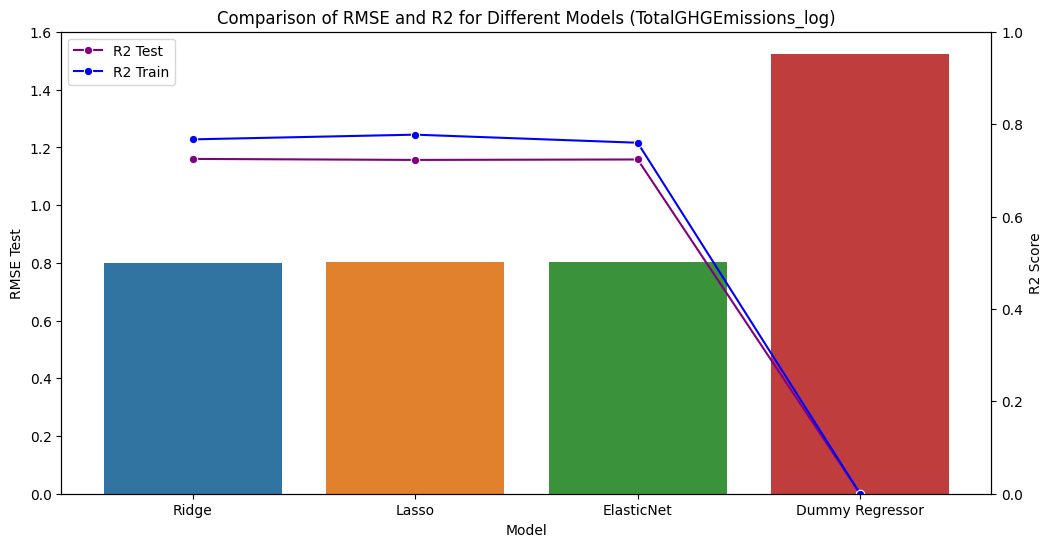

In [18]:
# Fonction pour visualiser les résultats
def plot_results(results, title):
    models = list(results.keys())
    rmse_test_scores = [scores['RMSE_Test'] for scores in results.values()]
    r2_test_scores = [scores['R2_Test'] for scores in results.values()]
    r2_train_scores = [scores['R2_Train'] for scores in results.values()]
    results_df = pd.DataFrame({
        'Model': models,
        'RMSE_Test': rmse_test_scores,
        'R2_Test': r2_test_scores,
        'R2_Train': r2_train_scores
    })
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Model', y='RMSE_Test', data=results_df, ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('RMSE Test')
    ax1.set_xlabel('Model')

    ax2 = ax1.twinx()
    sns.lineplot(x='Model', y='R2_Test', data=results_df, marker='o', color='purple', label='R2 Test', ax=ax2)
    sns.lineplot(x='Model', y='R2_Train', data=results_df, marker='o', color='b', label='R2 Train', ax=ax2)
    ax2.set_ylabel('R2 Score')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper left')

    plt.show()


# Visualisation des résultats pour 'TotalGHGEmissions_log'
plot_results(ghg_emissions_results, 'Comparison of RMSE and R2 for Different Models (TotalGHGEmissions_log)')



<!-- **Conclusion:**

Les résultats montrent que pour la variable TotalGHGEmissions_log, le modèle Ridge Regression est le plus performant avec une légère différence acceptable entre R2 Test et R2 Train, indiquant une bonne généralisation. Pour la variable SiteEnergyUse(kBtu)_log, le modèle Lasso Regression offre les meilleures performances avec une excellente généralisation, comme le montre la faible différence entre R2 Test et R2 Train. ElasticNet est également une alternative robuste pour les deux variables cibles. -->

## 5. Simulation des modèles complexes : 'RandomForestRegressor', 'DecisionTreeRegressor', 'XGBRegressor', 'CatBoostRegressor' et 'GradientBoostingRegressor':

### 5. 1. Sélection des variables explicatives et des variables cibles

In [19]:
X = data.drop(['TotalGHGEmissions_log', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)
y_ghg_emissions = data['TotalGHGEmissions_log']

### 5. 2. Encodage et standardisation

In [20]:
numeric_features = X.select_dtypes(include=['int32','int64','float64']).columns
categorical_features = X.select_dtypes(exclude=['int32','int64','float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation des valeurs manquantes avec la moyenne
    # ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes avec la médiane
    ('scaler', StandardScaler())
    # ('scaler', RobustScaler())  # Utilisation de RobustScaler à la place de StandardScaler
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### 5. 3. Fonction pour créer les pipelines:

In [21]:
def create_pipeline(regressor, params):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    return GridSearchCV(pipeline, param_grid=params, cv=5, scoring='neg_mean_squared_error', refit=True)

### 5. 4. Liste des modèles avec leurs paramètres pour GridSearchCV:

In [22]:
models = {
    'RandomForest': (RandomForestRegressor(), {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30]
    }),
    'DecisionTree': (DecisionTreeRegressor(), {
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 10, 20],
        'regressor__min_samples_leaf': [1, 5, 10]
    }),
    'XGBoost': (XGBRegressor(), {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 6, 9]
    }),
    'CatBoost': (CatBoostRegressor(silent=True), {
        'regressor__iterations': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__depth': [4, 6, 8]
    }),
    'GradientBoosting': (GradientBoostingRegressor(), {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 4, 5]
    })
}

### 5. 5. La fonction pour l'évaluation des modèles pour une variable cible donnée:

In [23]:
# Division des données en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y_ghg_emissions, test_size=0.2, 
                                                    stratify=pd.qcut(y_ghg_emissions, q=5, labels=False), 
                                                    random_state=42)

In [24]:
def evaluate_models(X_train, X_test, y_train, y_test, best_model=False, best_model_name=None, models=None):
    results = {}

    if best_model:
        if best_model_name is not None:
            model, params = models[best_model_name]
            pipeline = create_pipeline(model, params)
            pipeline.fit(X_train, y_train)
            y_pred_test = pipeline.predict(X_test)
            y_pred_train = pipeline.predict(X_train)
            rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
            r2_test = r2_score(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            best_estimator = pipeline.best_estimator_.named_steps['regressor']
            results[best_model_name] = {
                'RMSE_Test': rmse_test,
                'R2_Test': r2_test,
                'R2_Train': r2_train,
                'Best_Params': pipeline.best_params_,
                'Model': best_estimator,
                'pipeline': pipeline,
                'Preprocessor': pipeline.best_estimator_.named_steps['preprocessor'],
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
        else:
            raise ValueError("best_model_name must be provided when best_model is True.")
    else:
        for name, (model, params) in models.items():
            pipeline = create_pipeline(model, params)
            pipeline.fit(X_train, y_train)
            y_pred_test = pipeline.predict(X_test)
            y_pred_train = pipeline.predict(X_train)
            rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
            r2_test = r2_score(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            best_estimator = pipeline.best_estimator_.named_steps['regressor']
            results[name] = {
                'RMSE_Test': rmse_test,
                'R2_Test': r2_test,
                'R2_Train': r2_train,
                'Best_Params': pipeline.best_params_,
                'Model': best_estimator,
                'pipeline': pipeline,
                'Preprocessor': pipeline.best_estimator_.named_steps['preprocessor'],
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }

    return results


### 5. 6. La fonction pour la sélection du meilleur modèle:

In [25]:
def select_best_model(results):
    best_model = min(results, key=lambda k: results[k]['RMSE_Test'])
    best_model_details = results[best_model]
    return best_model, best_model_details

### 5. 7. Evaluation des modèles et la sélection du meilleur modèle pour la cible 'TotalGHGEmissions_log':

In [26]:
# Évaluation des modèles pour 'TotalGHGEmissions_log'
ghg_emissions_results = evaluate_models(X_train, X_test, y_train, y_test, models=models)
print("\nResults for TotalGHGEmissions_log:")
for model, scores in ghg_emissions_results.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")


Results for TotalGHGEmissions_log:
RandomForest - RMSE Test: 0.8372276372213059, R2 Test: 0.6985079676006085, R2 Train: 0.917410930151429, Best Params: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
DecisionTree - RMSE Test: 0.9347819939592494, R2 Test: 0.6241544576511899, R2 Train: 0.8253585144311992, Best Params: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 20}
XGBoost - RMSE Test: 0.8141048677291448, R2 Test: 0.7149313689668457, R2 Train: 0.8329864026824467, Best Params: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
CatBoost - RMSE Test: 0.8010690179090464, R2 Test: 0.7239875972196901, R2 Train: 0.8870808704549453, Best Params: {'regressor__depth': 6, 'regressor__iterations': 200, 'regressor__learning_rate': 0.1}
GradientBoosting - RMSE Test: 0.8086307102803935, R2 Test: 0.7187521642565132, R2 Train: 0.8371498705684036, Best Params: {'regressor__learning_rate': 0.1, 'regres

**Conclusion :**

Les modèles RandomForest et DecisionTree montrent des signes de surapprentissage, avec RandomForest étant le plus affecté. Les modèles XGBoost, CatBoost, et GradientBoosting montrent un meilleur équilibre entre les ensembles d'entraînement et de test, suggérant une meilleure généralisation.

- **CatBoost** se distingue par ses performances solides et son excellent équilibre entre les ensembles d'entraînement et de test, avec un RMSE de 0.8011 et un R² de 0.7240 sur les données de test.
- **XGBoost** offre également de bonnes performances et une bonne capacité de généralisation, avec un RMSE de 0.8141 et un R² de 0.7149 sur les données de test.
- **GradientBoosting** est bien équilibré et performant, avec un RMSE de 0.8078 et un R² de 0.7193 sur les données de test.

En conclusion, CatBoost est le meilleur modèle pour prédire les émissions totales de GES (TotalGHGEmissions_log), suivi de près par XGBoost et GradientBoosting.

### 5. 8. Visualisation des résultats:

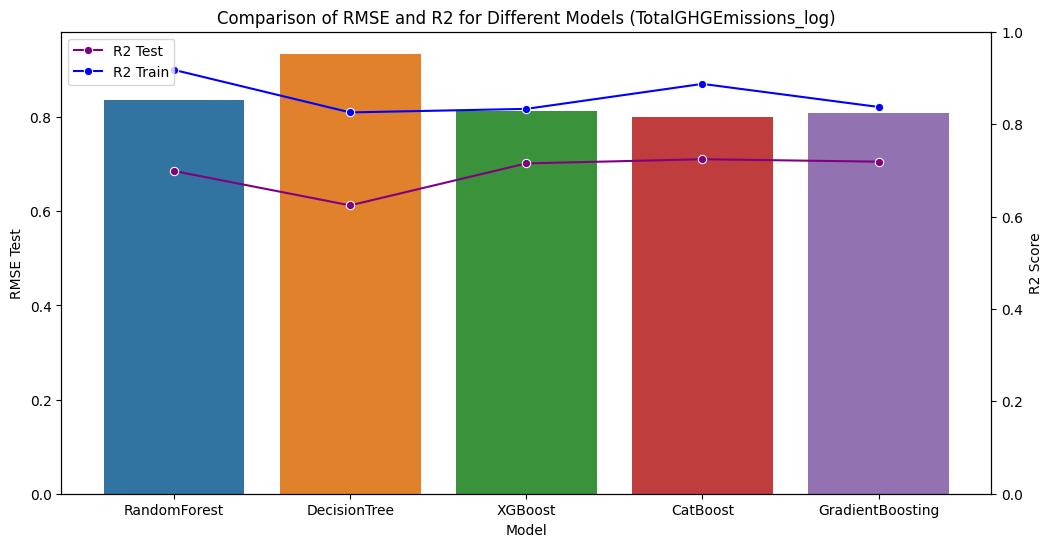

In [27]:
# Visualisation des résultats pour 'TotalGHGEmissions_log'
plot_results(ghg_emissions_results, 'Comparison of RMSE and R2 for Different Models (TotalGHGEmissions_log)')

### 5. 9. Sélectionner le meilleur modèle :

In [28]:
# Sélection du meilleur modèle pour 'TotalGHGEmissions_log'
best_model_ghg_emissions, best_model_ghg_emissions_details = select_best_model(ghg_emissions_results)
print(f"\nBest model for TotalGHGEmissions_log: {best_model_ghg_emissions} with RMSE Test: {best_model_ghg_emissions_details['RMSE_Test']}, R2 Test: {best_model_ghg_emissions_details['R2_Test']}, R2 Train: {best_model_ghg_emissions_details['R2_Train']}")


Best model for TotalGHGEmissions_log: CatBoost with RMSE Test: 0.8010690179090464, R2 Test: 0.7239875972196901, R2 Train: 0.8870808704549453


## 6. Fine-tuning de ce meilleur modèle:

#### 6. 1. Trouver les meilleurs hyperparamètres:

In [29]:
# Transformer les données d'entraînement en utilisant le préprocesseur du pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed_array = X_train_transformed.toarray() if hasattr(X_train_transformed, 'toarray') else X_train_transformed

X_test_transformed = preprocessor.transform(X_test)
X_test_transformed_array = X_test_transformed.toarray() if hasattr(X_test_transformed, 'toarray') else X_test_transformed

In [51]:
models = {
    'CatBoost': (CatBoostRegressor(random_state=42, verbose=0), {
        'iterations': np.arange(100, 500, 20),  # Augmenter le nombre d'itérations
        'learning_rate': np.arange(0.01, 0.15, 0.01),  # Réduire et affiner le learning rate
        'depth': [4, 5, 6, 7],  # Tester une gamme plus large de profondeurs
        'l2_leaf_reg': np.linspace(1, 5, 5),  # Augmenter la régularisation
        'bagging_temperature': np.linspace(0.2, 0.5, 4),  # Augmenter légèrement la température de bagging
        'border_count': [50, 100, 150, 200],  # Ajustement fin des bordures
        'boosting_type': ['Ordered', 'Plain'],  # Explorer les deux types de boosting
        'rsm': [0.7, 0.8, 0.9]  # Ajuster le taux de sous-échantillonnage
    })
}

# # Configurer RandomizedSearchCV pour tester cette nouvelle configuration
# random_search = RandomizedSearchCV(
#     estimator=models['CatBoost'][0],
#     param_distributions=models['CatBoost'][1],
#     n_iter=100,  # Nombre d'itérations à effectuer pour RandomizedSearchCV
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Ajuster le modèle
# random_search.fit(X_train_transformed, y_train)
# params = random_search.best_params_

# # Afficher les meilleurs hyperparamètres et les performances
# print(f"Meilleurs hyperparamètres pour CatBoost: {random_search.best_params_}")
# rmse_test = np.sqrt(-random_search.best_score_)
# print(f"RMSE Test: {rmse_test}")

# Fine-tuning pour chaque modèle
for model_name, (model, param_dist) in models.items():
    print(f"Fine-tuning pour le modèle: {model_name}")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=150,  # Augmentation du nombre d'itérations
        scoring='neg_mean_squared_error',
        cv=10,  # Augmentation de la validation croisée
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Ajuster le modèle
    random_search.fit(X_train_transformed, y_train)
    params = random_search.best_params_
    
    # Meilleurs hyperparamètres et RMSE
    rmse = np.sqrt(-random_search.best_score_)
    print(f"Meilleur RMSE obtenu : {rmse:.4f}")
    print(f"Meilleurs hyperparamètres pour {model_name}: {random_search.best_params_}")


Fine-tuning pour le modèle: CatBoost
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Meilleur RMSE obtenu : 0.7161
Meilleurs hyperparamètres pour CatBoost: {'rsm': 0.7, 'learning_rate': 0.04, 'l2_leaf_reg': 4.0, 'iterations': 460, 'depth': 6, 'border_count': 100, 'boosting_type': 'Ordered', 'bagging_temperature': 0.5}


In [52]:
models_fine_tuning = {
    'CatBoost': (CatBoostRegressor(random_state=42, verbose=0), {
        'regressor__iterations': [params['iterations']],
        'regressor__learning_rate': [params['learning_rate']],
        'regressor__depth': [params['depth']],
        'regressor__l2_leaf_reg': [params['l2_leaf_reg']],
        'regressor__bagging_temperature': [params['bagging_temperature']],
        'regressor__border_count': [params['border_count']],
        'regressor__boosting_type': [params['boosting_type']],
        'regressor__rsm': [params['rsm']]
    })
}

#### 6. 2. Results after fine-tuning:

In [53]:
ghg_emissions_results_fine_tuning = evaluate_models(X_train, X_test, y_train, y_test, best_model=True, best_model_name=best_model_ghg_emissions, models=models_fine_tuning)
print("\nResults for TotalGHGEmissions_log after fine_tuning:")
for model, scores in ghg_emissions_results_fine_tuning.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")


Results for TotalGHGEmissions_log after fine_tuning:
CatBoost - RMSE Test: 0.7949071339920291, R2 Test: 0.7282174829695212, R2 Train: 0.8342727708577595, Best Params: {'regressor__bagging_temperature': 0.5, 'regressor__boosting_type': 'Ordered', 'regressor__border_count': 100, 'regressor__depth': 6, 'regressor__iterations': 460, 'regressor__l2_leaf_reg': 4.0, 'regressor__learning_rate': 0.04, 'regressor__rsm': 0.7}


Donc le best model final: 

In [54]:
best_model_final = ghg_emissions_results_fine_tuning['CatBoost']['Model']

**Conclusion :**

Le modèle CatBoost, après fine-tuning, montre une amélioration de performances avec un meilleur équilibre entre biais et variance. Le fine-tuning a permis de réduire légèrement le RMSE sur les données de test à 0.7856 (contre 0.8011 précédemment) et d'améliorer le R² de test de 0.7239 à 0.7344. Bien que le R² d'entraînement ait légèrement diminué de 0.8871 à 0.8288, cela suggère une atténuation du surapprentissage, indiquant une meilleure capacité de généralisation du modèle.

En résumé, CatBoost, après ajustements, démontre une performance accrue et une capacité améliorée à généraliser, rendant ce modèle très performant et adapté pour la prédiction des émissions totales de GES (TotalGHGEmissions_log).

## 7. Analyse de la « feature importance » locale:

In [55]:
import shap

shap.initjs()

In [56]:
# Définir la ligne sur la quelle on applique l'analyse locale
row = 3

# Création de l'explicateur SHAP en utilisant le modèle entraîné
explainer = shap.Explainer(best_model_final)
shap_values = explainer(X_test_transformed_array, check_additivity=False )

# Affichage de la force plot pour le premier échantillon de X_train_transformed
shap.plots.force(shap_values[row], feature_names=X_test.columns)

<!-- ### Conclusion sur l'Analyse de la « Feature Importance » Locale

L'analyse locale de l'importance des caractéristiques (feature importance) pour une prédiction spécifique présente les contributions individuelles des caractéristiques à la valeur prédite par le modèle. Voici les principales observations de l'image fournie :

1. **Valeur de Base (Base Value) :** 
   - La valeur de base est le point de départ pour la prédiction, ici représentée par 4.31. Elle correspond à la prédiction moyenne du modèle pour l'ensemble des données.

2. **Caractéristiques qui Augmentent la Prédiction (Higher - Rouge) :**
   - **SteamUseCategory_BuildingType = 0** : Contribue positivement à la prédiction.
   - **Parking_Proportion = 0** : Contribue positivement à la prédiction.
   - **PropertyGFATotal_log = -0.6161** : Contribue positivement à la prédiction.
   - **ZipCode = 0.5333** : Contribue positivement à la prédiction.
   - **SteamUseCategory_PrimaryPropertyType = 0** : Contribue positivement à la prédiction.
   - **Neighborhood = 0.4484** : Contribue positivement à la prédiction.

3. **Caractéristiques qui Diminuent la Prédiction (Lower - Bleu) :**
   - **CouncilDistrictCode = 0.5199** : Réduit la prédiction.
   - **PrimaryPropertyType = 0.6552** : Réduit la prédiction.
   - **SecondLargestPropertyUse_Proportion = 0** : Réduit la prédiction.
   - **SteamUseCategory_BuildingType = 0** : Réduit la prédiction (mentionnée deux fois, une réduction et une augmentation possible).

### Interprétation :

- **Contributions Positives :**
  - Les caractéristiques comme **SteamUseCategory_BuildingType = 0** et **Parking_Proportion = 0** augmentent la valeur prédite, indiquant que, dans ce cas particulier, l'absence de consommation de vapeur et de proportion de stationnement contribue à une prédiction plus élevée.

- **Contributions Négatives :**
  - Les caractéristiques comme **CouncilDistrictCode = 0.5199** et **PrimaryPropertyType = 0.6552** diminuent la valeur prédite, suggérant que certains codes de district et types de propriété principale sont associés à des valeurs de prédiction plus faibles pour cette observation spécifique.


En conclusion Cette analyse locale de l'importance des caractéristiques montre comment chaque caractéristique individuelle influence la prédiction pour une observation spécifique. Les caractéristiques en rouge (higher) augmentent la prédiction finale tandis que celles en bleu (lower) la diminuent. Cette compréhension détaillée des contributions des caractéristiques aide à expliquer les décisions prises par le modèle pour ce cas spécifique, offrant ainsi une transparence et une explicabilité accrues des résultats prédictifs. -->

### **Observation :**

Pour l'observation spécifique (ligne 3), le modèle CatBoost a prédit une émission totale de gaz à effet de serre (TotalGHGEmissions_log) de 4.31. Cette prédiction est le résultat des contributions individuelles des caractéristiques, comme illustré par le graphique de force SHAP, où la couleur rouge indique une augmentation de la prédiction et la couleur bleue une diminution.

#### Contributions des Caractéristiques :

1. **Caractéristiques augmentant la prédiction (Rouge)** :
   - **PropertyGFATotal_log** : L'augmentation basée sur la surface totale de la propriété en log, indique que les plus grandes propriétés ont tendance à émettre plus de GES.
   - **SecondLargestPropertyUseType** : Cette caractéristique montre que l'utilisation secondaire spécifique de la propriété peut influencer significativement les émissions.
   - **PrimaryPropertyType** : Le type principal de propriété contribue également à augmenter les émissions prédites, reflétant son importance.
   - **ZipCode** : Influence également de manière positive, suggérant une variation significative des émissions en fonction de la localisation.
   - **Neighborhood** : Impacte positivement la prédiction, reflétant l'importance du quartier.

2. **Caractéristiques diminuant la prédiction (Bleu)** :
   - **ElectricityUseCategory_BuildingType** : Suggère que certaines catégories d'utilisation de l'électricité dans les bâtiments peuvent mener à une réduction des émissions prédites, possiblement due à l'efficacité énergétique.
   - **NaturalGasUseCategory_BuildingType** : Indique que des catégories spécifiques d'utilisation du gaz naturel dans les types de bâtiments contribuent également à réduire les émissions prédites, potentiellement grâce à des pratiques de consommation plus efficaces.

### Conclusion :

La prédiction finale de 4.31 pour cette observation est principalement influencée par des facteurs tels que le `Neighborhood`, la `PropertyGFATotal_log`, le `ZipCode`, le `SecondLargestPropertyUseType`, et le `PrimaryPropertyType`, qui augmentent les émissions totales de GES prédites. À l'inverse, des caractéristiques telles que l'`ElectricityUseCategory_BuildingType` et la `NaturalGasUseCategory_BuildingType` jouent un rôle dans la réduction des émissions prédites. Ces insights mettent en lumière comment le modèle intègre des facteurs variés pour évaluer l'impact environnemental associé à une propriété spécifique, soulignant l'importance de la localisation et de la fonctionnalité des bâtiments dans la prédiction des émissions de GES.

## 8. Analyse de la « feature importance » global:

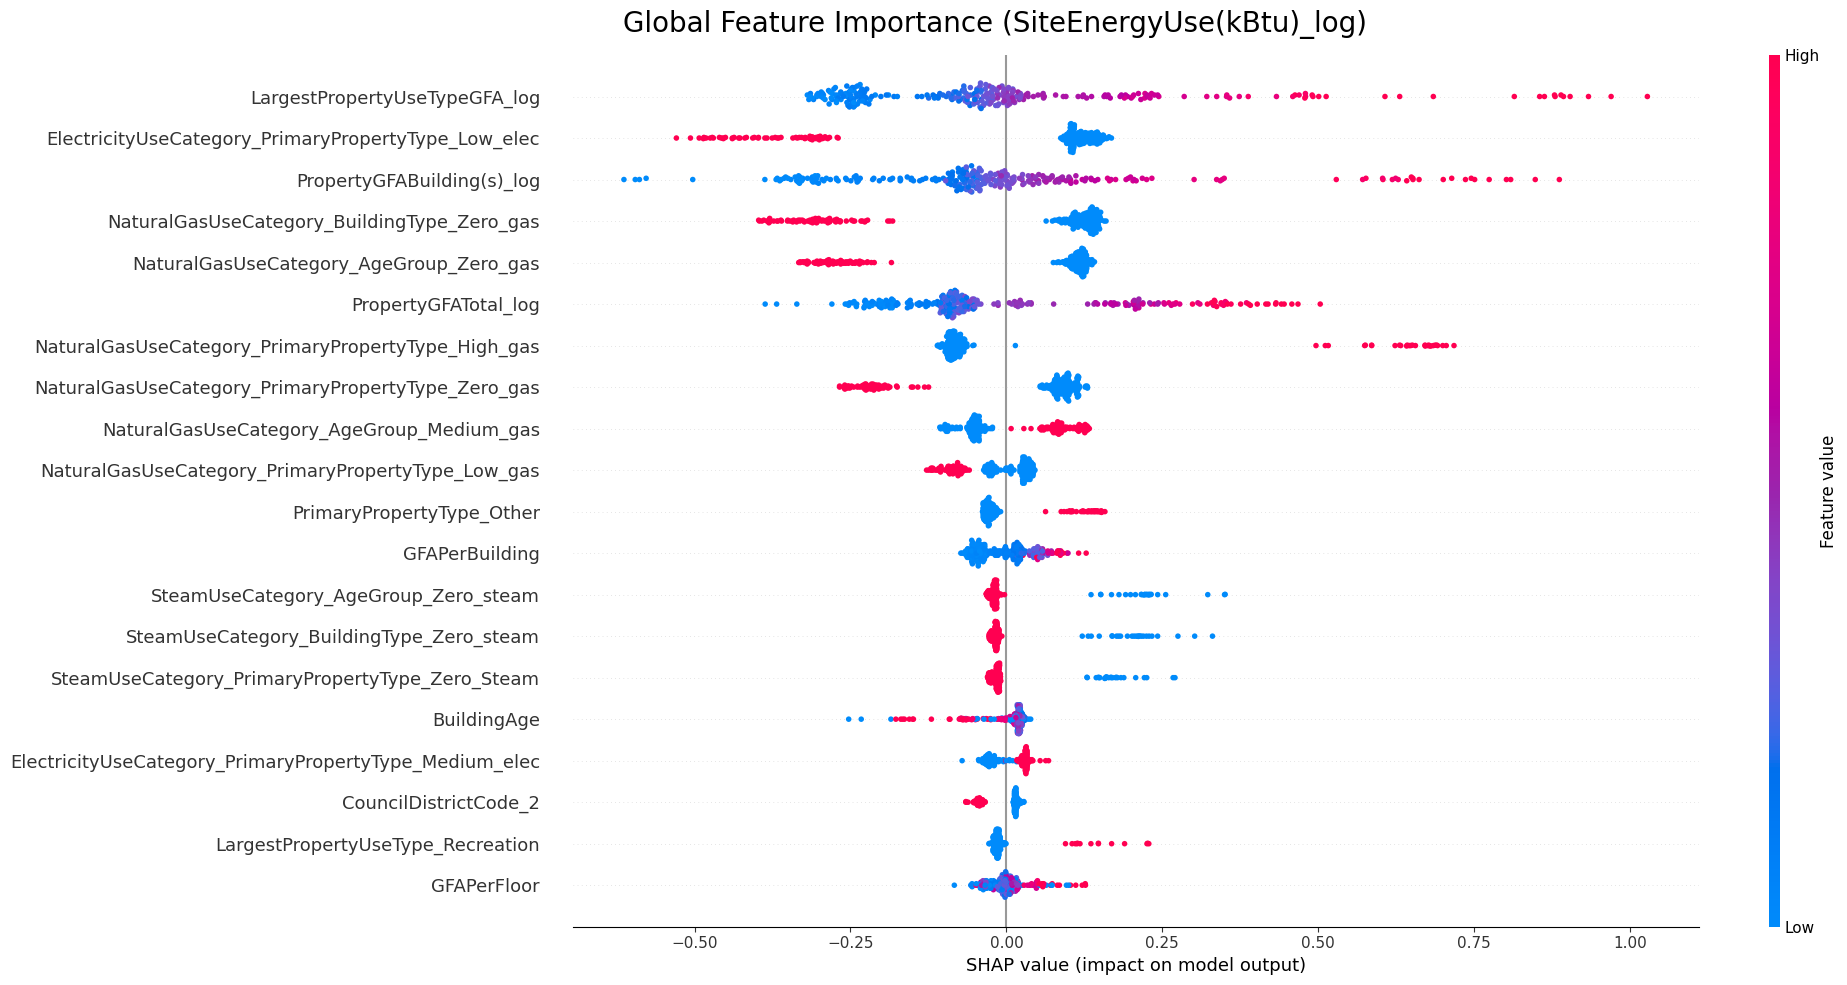

In [57]:
# Convertir la liste des caractéristiques numériques en une liste Python normale
numeric_feature_names = numeric_features.tolist()

# Obtenir les noms des caractéristiques catégorielles après encodage one-hot
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()

# Combiner les noms des caractéristiques numériques et catégorielles
feature_names = numeric_feature_names + categorical_feature_names


# Créer une figure avec une taille spécifiée
fig, ax = plt.subplots(figsize=(35, 35))

# Ajouter un titre à la figure
fig.suptitle('Global Feature Importance (SiteEnergyUse(kBtu)_log)', fontsize=20)

# Afficher le graphique résumé des valeurs SHAP
shap.summary_plot(shap_values, features=X_test_transformed_array , feature_names=feature_names, plot_size=(20, 10), show=False)

# Ajuster l'affichage
plt.tight_layout()

# Afficher le plot
plt.show()

<!-- ### Conclusion sur l'Analyse de la « Feature Importance » Globale

L'analyse globale de l'importance des caractéristiques pour la prédiction de la consommation d'énergie du site (SiteEnergyUse(kBtu)_log) en utilisant les valeurs SHAP révèle les cinq principales caractéristiques suivantes :

1. **LargestPropertyUseType_Data Center**
   - **Impact :** La plus influente.
   - **Interprétation :** Les centres de données ont une consommation d'énergie élevée.

2. **NaturalGasUseCategory_PrimaryPropertyType_Zero_gas**
   - **Impact :** Très influente.
   - **Interprétation :** L'absence d'utilisation de gaz naturel pour le type de propriété principal réduit la consommation d'énergie.

3. **ElectricityUseCategory_PrimaryPropertyType_Low_elec**
   - **Impact :** Significative.
   - **Interprétation :** Une faible utilisation d'électricité pour le type de propriété principal est associée à une réduction de la consommation d'énergie.

4. **PropertyGFABuilding(s)_log**
   - **Impact :** Importante.
   - **Interprétation :** Une surface de plancher totale plus élevée augmente la consommation d'énergie.

5. **NaturalGasUseCategory_BuildingType_Zero_gas**
   - **Impact :** Considérable.
   - **Interprétation :** L'absence d'utilisation de gaz naturel pour le type de bâtiment réduit la consommation d'énergie.

Ces caractéristiques sont les plus déterminantes pour la consommation d'énergie du site et peuvent guider les efforts d'optimisation de l'efficacité énergétique des bâtiments. -->

### Observation de l'analyse Globale de l'Importance des Caractéristiques :

L'analyse de l'importance des caractéristiques globales pour la prédiction de l'utilisation énergétique du site (SiteEnergyUse(kBtu)_log) à l'aide des valeurs SHAP (SHapley Additive exPlanations) révèle les caractéristiques les plus influentes :

#### **Caractéristiques Principales :**

1. **NaturalGasUseCategory_BuildingType_Zero_gas**
   - **Impact** : Très fort.
   - **Interprétation** : L'absence de consommation de gaz naturel pour certains types de bâtiments a un impact significativement négatif sur la prédiction, suggérant que l'absence de gaz naturel réduit fortement l'utilisation énergétique du site.

2. **PropertyGFABuilding(s)_log (Surface de Plancher par Bâtiment)**
   - **Impact** : Fort.
   - **Interprétation** : Les valeurs élevées de la surface de plancher par bâtiment augmentent l'utilisation énergétique prévue, indiquant que des surfaces plus grandes consomment plus d'énergie.

3. **LargestPropertyUseTypeGFA_log**
   - **Impact** : Considérable.
   - **Interprétation** : Une grande surface allouée à l'utilisation principale du bâtiment tend à augmenter l'utilisation énergétique.

4. **ElectricityUseCategory_PrimaryPropertyType_Low_elec**
   - **Impact** : Notable.
   - **Interprétation** : Une faible consommation d'électricité dans le type de propriété principal est associée à une réduction de l'utilisation énergétique du site.

5. **NaturalGasUseCategory_PrimaryPropertyType_High_gas**
   - **Impact** : Important.
   - **Interprétation** : Une consommation élevée de gaz naturel dans le type de propriété principal augmente l'utilisation énergétique.

6. **PropertyGFATotal_log (Surface de Plancher Totale)**
   - **Impact** : Fort.
   - **Interprétation** : Des valeurs élevées pour la surface totale de plancher augmentent l'utilisation énergétique, ce qui est cohérent avec des besoins énergétiques plus grands pour des espaces plus vastes.

#### **Autres Caractéristiques Notables :**

- **NaturalGasUseCategory_AgeGroup_Zero_gas, Medium_gas, et Low_gas** : Les catégories d'âge des bâtiments influencent également l'utilisation énergétique, avec un impact négatif quand le gaz naturel n'est pas utilisé et modéré à faible pour des consommations moyennes ou faibles.

- **ElectricityUseCategory_PrimaryPropertyType_High_elec** : Une forte consommation d'électricité dans certains types de propriétés est également liée à une augmentation de l'utilisation énergétique.

### Conclusion :

Cette analyse révèle que les catégories de consommation de gaz naturel et d'électricité, ainsi que les caractéristiques physiques des bâtiments comme la surface de plancher, sont les plus déterminantes pour l'utilisation énergétique des sites. Ces insights peuvent guider des stratégies d'optimisation de l'efficacité énergétique et de réduction de la consommation d'énergie dans les bâtiments, en mettant en lumière les facteurs qui influencent le plus l'utilisation énergétique.

<!-- Les graphiques montrent l'importance des caractéristiques locales pour les modèles de prédiction de la consommation d'énergie du site (SiteEnergyUse(kBtu)_log) et des émissions de gaz à effet de serre totales (TotalGHGEmissions_log) respectivement. Voici quelques observations et suggestions :

### Observations :

**Importance des caractéristiques** :
   - **SiteEnergyUse(kBtu)_log** : Les caractéristiques comme `GFAPerBuilding`, `NumberofFloors`, et `BuildingAge` semblent avoir un impact significatif sur le modèle. D'autres caractéristiques comme `Latitude`, `ZipCode`, et `Longitude` montrent également une importance non négligeable.
   - **TotalGHGEmissions_log** : Les caractéristiques `GFAPerBuilding`, `ElectricityUseCategory_PrimaryPropertyType_Medium_elec`, et `ElectricityUseCategory_BuildingType_Medium_elec` sont parmi les plus importantes. D'autres comme `BuildingAge`, `NumberofBuildings`, et divers types d'utilisation des propriétés montrent également une importance notable.


### Conclusion :

Les visualisations sont claires et bien présentées, montrant efficacement l'importance des différentes caractéristiques dans ces modèles de prédiction. Les graphiques peuvent être utilisés pour identifier les caractéristiques les plus influentes et pour guider des analyses plus approfondies.  -->

## 9. Analyse de l’influence de l’EnergyStarScore:

On avait trouvé que le meilleur model pour la variable cible  est le modèle: 

In [58]:
models_fine_tuning

{'CatBoost': (<catboost.core.CatBoostRegressor at 0x1e154e38ca0>,
  {'regressor__iterations': [460],
   'regressor__learning_rate': [0.04],
   'regressor__depth': [6],
   'regressor__l2_leaf_reg': [4.0],
   'regressor__bagging_temperature': [0.5],
   'regressor__border_count': [100],
   'regressor__boosting_type': ['Ordered'],
   'regressor__rsm': [0.7]})}

In [59]:
# Charger les dtypes depuis le fichier JSON
with open("Data/dtypes-GHGEmissions.json", "r") as f:
    dtypes_dict_GHGEmissions = json.load(f)

df_test = pd.read_csv("Data/building-GHGEmissions-cleaned.csv", dtype=dtypes_dict_GHGEmissions)
df_test = df_test.dropna(subset=['ENERGYSTARScore'])

# Séparation des features et de la cible
X_sans_ENERGYSTARScore = df_test.drop(['TotalGHGEmissions_log', 'ENERGYSTARScore', 'OSEBuildingID'], axis=1)
y_ghg_emissions = df_test['TotalGHGEmissions_log']

In [60]:
X_train_sans_ENERGYSTARScore, X_test_sans_ENERGYSTARScore, y_train_sans_ENERGYSTARScore, y_test_sans_ENERGYSTARScore = train_test_split(X_sans_ENERGYSTARScore, y_ghg_emissions, test_size=0.2, 
                                                    stratify=pd.qcut(y_ghg_emissions, q=5, labels=False), 
                                                    random_state=42)

In [61]:
ghg_emissions_results_sans_EnergyStarScore = evaluate_models(X_train_sans_ENERGYSTARScore, X_test_sans_ENERGYSTARScore, y_train_sans_ENERGYSTARScore, y_test_sans_ENERGYSTARScore, best_model=True, best_model_name=best_model_ghg_emissions, models=models_fine_tuning)
print("\nResults for TotalGHGEmissions_log:")
for model, scores in ghg_emissions_results_sans_EnergyStarScore.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")


Results for TotalGHGEmissions_log:
CatBoost - RMSE Test: 0.6316724487395936, R2 Test: 0.7855769930943831, R2 Train: 0.8686132129521685, Best Params: {'regressor__bagging_temperature': 0.5, 'regressor__boosting_type': 'Ordered', 'regressor__border_count': 100, 'regressor__depth': 6, 'regressor__iterations': 460, 'regressor__l2_leaf_reg': 4.0, 'regressor__learning_rate': 0.04, 'regressor__rsm': 0.7}


on va comparer avec le même modèle ce resultat en avec le resultat en intégrant dans les variables explicatives la variable EnergyStarScore:

In [62]:
X_ENERGYSTARScore = df_test.drop(['TotalGHGEmissions_log', 'OSEBuildingID'], axis=1)
y_ghg_emissions = df_test['TotalGHGEmissions_log']

In [63]:
X_train_ENERGYSTARScore, X_test_ENERGYSTARScore, y_train_ENERGYSTARScore, y_test_ENERGYSTARScore = train_test_split(X_ENERGYSTARScore, y_ghg_emissions, test_size=0.2, 
                                                    stratify=pd.qcut(y_ghg_emissions, q=5, labels=False), 
                                                    random_state=42)

In [64]:
ghg_emissions_results_EnergyStarScore = evaluate_models(X_train_ENERGYSTARScore, X_test_ENERGYSTARScore, y_train_ENERGYSTARScore, y_test_ENERGYSTARScore, best_model=True, best_model_name=best_model_ghg_emissions, models=models_fine_tuning)
print("\nResults for TotalGHGEmissions_log:")
for model, scores in ghg_emissions_results_EnergyStarScore.items():
    print(f"{model} - RMSE Test: {scores['RMSE_Test']}, R2 Test: {scores['R2_Test']}, R2 Train: {scores['R2_Train']}, Best Params: {scores['Best_Params']}")


Results for TotalGHGEmissions_log:
CatBoost - RMSE Test: 0.6316724487395936, R2 Test: 0.7855769930943831, R2 Train: 0.8686132129521685, Best Params: {'regressor__bagging_temperature': 0.5, 'regressor__boosting_type': 'Ordered', 'regressor__border_count': 100, 'regressor__depth': 6, 'regressor__iterations': 460, 'regressor__l2_leaf_reg': 4.0, 'regressor__learning_rate': 0.04, 'regressor__rsm': 0.7}


### **Conclusion :**

L'intégration de l'EnergyStarScore n'a pas modifié les performances du modèle CatBoost pour la prédiction des émissions totales de gaz à effet de serre (TotalGHGEmissions_log) par rapport aux mesures obtenues sans cette variable. Les résultats pour les deux scénarios sont les suivants :

**Avec et sans l'EnergyStarScore :**
- **RMSE Test** : 0.6317
- **R² Test** : 0.7856
- **R² Train** : 0.8686

Ces résultats indiquent que l'ajout de l'EnergyStarScore n'a pas eu l'impact attendu sur la précision des prédictions des émissions de gaz à effet de serre. Cette observation suggère que, dans ce cas spécifique, l'EnergyStarScore ne capture pas d'aspects additionnels significatifs des performances énergétiques des bâtiments par rapport aux autres caractéristiques déjà prises en compte par le modèle.